In [2]:
import pygame
import random
import numpy as np
import cv2
import os.path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten, ZeroPadding2D, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.utils import to_categorical
import pandas as pd 
import re
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter
import math
import time
import statistics
from os import listdir
from shutil import copyfile

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
pathname = r"D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS"
datadirname = "data_new"
#testdirname = "test"
#validdirname = "valid"
modeldirname = "model"
datacsvname = "data.csv"
modeljsonname="model-regr.json"
modelweightname="model-regr.h5"
dim = (50,50) 
actionstonum = {"RIGHT": 0,
           "LEFT": 1,
           "SPACE" : 2,
          }
numtoactions = {0: "RIGHT",
           1: "LEFT",
           2: "SPACE",
          }
scores = []
overallscores = []
manual = False
modulo_counter = 3

assert(os.path.isdir(pathname))

In [4]:
def create_q_model():
        # Network defined by the Deepmind paper
        inputs = layers.Input(shape=(dim[0], dim[1], 3,))

        # Convolutions on the frames on the screen
        layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
        layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
        layer3 = layers.Conv2D(128, 3, strides=1, activation="relu")(layer2)

        layer4 = layers.Flatten()(layer3)

        layer5 = layers.Dense(512, activation="relu")(layer4)
        layer6 = layers.Dense(128, activation="relu")(layer5)
        action = layers.Dense(3, activation="linear")(layer6)

        return keras.Model(inputs=inputs, outputs=action)

In [5]:
model = create_q_model()
model_json = model.to_json()
with open(os.path.join(pathname, modeldirname,modeljsonname), "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(pathname, modeldirname,modelweightname))

In [27]:
class Alien:
    def __init__(self, game, x, y):
        self.x = x
        self.game = game
        self.y = y
        self.size = 40
        self.will_be_hit = False

    def draw(self):
        pygame.draw.rect(self.game.screen,(0, 0, 255),  # barva objektu
                         pygame.Rect(self.x, self.y, self.size, self.size))
        self.y += 1.8

    def checkCollision(self, game):
        for rocket in game.rockets:
            if (rocket.x < self.x + self.size and rocket.x + rocket.size > self.x and rocket.y < self.y + self.size and rocket.y > self.y - self.size):
                game.rockets.remove(rocket)
                game.aliens.remove(self)


class Hero:
    def __init__(self, game, x, y):
        self.x = x
        self.game = game
        self.y = y

    def draw(self):
        pygame.draw.rect(self.game.screen,
                         (255, 255, 255),
                         pygame.Rect(self.x, self.y, 40, 20))


class Rocket:
    def __init__(self, game, x, y):
        self.x = x
        self.y = y
        self.game = game
        self.size = 15

    def draw(self):
        pygame.draw.rect(self.game.screen,(0, 255, 0),pygame.Rect(self.x, self.y, self.size, self.size))
        self.y -= 9 


In [28]:
class Game:
    screen = None
    
    lost = False
    done = False

    def __init__(self, width, height, epsilon, lr=1e-3, checkpointparname="model-regr.h5"):
        
        self.currentAction = ""
                       
        self.shufflelist = []
        
        self.width = width
        self.height = height
        self.screen = pygame.display.set_mode((int(width), int(height)))
        self.screen.fill([255,0,0])

        self.imgresh1 = None
        self.imgresh2 = None

        self.reward = 0
        self.MAXREWARD = 1
        self.HITREWARD = 1
        self.PENALTY = -1
        self.FIREPENALTY = -0.3 
        self.MOVEPENALTY = 0
        self.NOTFIREPENALTY = -0.5
        
        self.BATCHSIZE = 19
        self.DISCOUNT = 0.99
        self.ALPHA = 0.3
        
        
        self.EPSILON = epsilon
        
        self.ALIENPROB = 0.4
        
        self.REPLAYSIZE = 30_000
        self.overall_score = 0
        self.overall_numbatches = 0
        self.overall_accumulatedstates = np.array([0.0,0.0,0.0,0.0])
        
        self.scores = []
        
        
        self.path = os.path.join(pathname, datadirname)
        self.modelpath =  os.path.join(pathname, modeldirname)
        
        self.filename = "data.csv"
        
        self.model = create_q_model()
        self.model_target = create_q_model()
        #self.load_checkpoint()

        self.learningrate = lr
        self.optimizer = keras.optimizers.Adam(learning_rate=self.learningrate, clipnorm=1.0)
        self.loss_function = keras.losses.Huber()

        self.checkpointname = os.path.join(pathname, modeldirname,checkpointparname)
        print(f"loading checkpoint: {self.checkpointname}")
        self.model_target.load_weights(self.checkpointname)
        self.model.load_weights(self.checkpointname)
        
        self.model.compile(loss='mse', optimizer=self.optimizer)
        
        self.overall_scores=[]
        self.checkpoint_counter=0
        
        self.debugcounter = 0
        
        self.counter_alien_center = 0

        
    def initialize(self, i, j):
        pygame.init()
        self.aliens = []
        self.rockets = []
        self.clock = pygame.time.Clock()
        self.hero = Hero(self, self.width / 2, self.height - 20)
        self.firstFire = True
        
        #Generator
        margin = 30  # mezera od okraju obrazovky
        width = 50  # mezera mezi alieny
        pygame.display.set_caption(f"{i}-{j}")
        self.screen = pygame.display.set_mode((int(self.width), int(self.height)))
        for x in range(margin, self.width - margin, width):
            for y in range(margin, int(self.height / 2), width):
                if(random.random()<=self.ALIENPROB):
                    self.aliens.append(Alien(self, x, y))
                    
        self.rocket = None
        self.numbatches = 0
        self.counter_alien_center = 0
    

    def run(self, i_index):
        i = i_index + self.get_maxi() + 1
        #print("i is ", i)
        j = 0
        while True:
            #print("i 1 is ", i)
            img1 = np.frombuffer(pygame.image.tostring(self.screen, "RGB"), dtype=np.uint8)
            self.imgresh1 = np.reshape(img1,(self.width,self.height, 3))
            self.imgresh1 = cv2.resize(self.imgresh1, dim, interpolation = cv2.INTER_NEAREST )
            self.imgresh1 = cv2.cvtColor(self.imgresh1, cv2.COLOR_BGR2RGB)
            
            prediction = self.model.predict(np.array([self.imgresh1])/255.0, batch_size=1, verbose=0)
            theaction = np.argmax(prediction[0])

                

            #current_state = np.array(self.imgresh1, dtype=np.float32)/255.0
            #state_tensor = tf.convert_to_tensor(current_state)
            #state_tensor = tf.expand_dims(state_tensor, 0)
            #action_probs = self.model(state_tensor, training=False)
            #theaction = tf.argmax(action_probs[0]).numpy()            

            #win
            if len(self.aliens) == 0:
                pygame.display.flip()                         
                pygame.quit()
                return

            pressed = pygame.key.get_pressed()
            if pressed[pygame.K_LEFT]:
                self.currentAction = "LEFT"
                
            elif pressed[pygame.K_RIGHT]:
                self.currentAction = "RIGHT"
                
            elif pressed[pygame.K_q]:
                pygame.display.flip()                         
                pygame.quit()
                return

            for event in pygame.event.get():
                if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE and not self.lost:
                    self.currentAction = "SPACE"
                

            if np.random.random() > self.EPSILON:
                self.currentAction = numtoactions[theaction]
            else:
                self.currentAction = numtoactions[random.randint(0,2)]
                
            #self.currentAction = numtoactions[random.randint(0,2)]
            
            if self.counter_alien_center % modulo_counter == 0:
                alien_sort = sorted([(alien.y,alien.x) for alien in self.aliens])[::-1]
                alien_max = []
                for ind in range(len(alien_sort)):
                    if alien_sort[ind][0] == alien_sort[0][0]:
                        alien_max.append(alien_sort[ind])
                    else:
                        break
                alien_next = min([(abs(self.hero.x - alien[1]),alien[1]) for alien in alien_max])
                if alien_next[1] > self.hero.x:
                    self.currentAction = "RIGHT"
                elif alien_next[1] < self.hero.x:
                    self.currentAction = "LEFT"
                self.counter_alien_center = 0
                
            
            self.counter_alien_center += 1
                
                
            if self.currentAction == "RIGHT":
                self.hero.x += 6 if self.hero.x < self.width - 20 else 0  # prava hranice
                self.reward = self.MOVEPENALTY
                
            if self.currentAction == "LEFT":
                self.hero.x -= 6 if self.hero.x > 20 else 0  # leva hranice plochy
                self.reward = self.MOVEPENALTY
            
            if len(self.rockets) == 0:
                self.firstFire = True
            
            if self.currentAction == "SPACE":
                if self.firstFire or self.rockets[-1].y + self.rockets[-1].size < self.hero.y:
                    self.rockets.append(Rocket(self, self.hero.x, self.hero.y))
                    if self.checkHit(self.rockets[-1]):
                        self.reward = self.HITREWARD
                        self.train(i,j,False)
                    else:
                        self.reward = self.FIREPENALTY
                else:
                    reward = self.NOTFIREPENALTY
                self.firstFire = False
            
            if manual == True:
                self.currentAction = "LEFT"

            pygame.display.flip()
            self.clock.tick(60)
            self.screen.fill((255, 0, 0))
            

            endofgame = False
            
            for alien in self.aliens:
                alien.draw()
                alien.checkCollision(self)
                if (alien.y > (self.height-60)):
                    endofgame = True

                    
            for rocket in self.rockets:
                rocket.draw()

            if not self.lost: self.hero.draw()

            pygame.display.update()

            img2 = np.frombuffer(pygame.image.tostring(self.screen, "RGB"), dtype=np.uint8)
            self.imgresh2 = np.reshape(img2,(self.width,self.height, 3))
            self.imgresh2 = cv2.resize(self.imgresh2, dim, interpolation = cv2.INTER_NEAREST )
            self.imgresh2 = cv2.cvtColor(self.imgresh2, cv2.COLOR_BGR2RGB)
            
            
            
            #print(self.imgresh1.mean())
            #print("i 2 is ", i)    
                
            if endofgame == True:
                self.reward = self.PENALTY
                self.train(i,j, True)
                self.scores.append(len(self.aliens))
                pygame.display.flip()                         
                pygame.quit()
                return

            self.train_short_memory(i, j, self.imgresh1, theaction, self.reward, self.imgresh2, False)
            
            j += 1
            
            
    

    def checkHit(self, rocket):
        for alien in self.aliens:
            if (rocket.x < alien.x + alien.size and 
                    rocket.x + rocket.size > alien.x and
                    not alien.will_be_hit):
                alien.will_be_hit = True
                return True
            
            
    def write(self, i, j):
        cv2.imwrite(os.path.join(self.path,"current_{}_{}.png".format(i,j)), self.imgresh1)
        cv2.imwrite(os.path.join(self.path,"next_{}_{}.png".format(i,j)), self.imgresh2)
        
                
    def train_short_memory(self, i, j, state, action, reward, next_state, done):
        if False:
            currentstate = "current_{}_{}.png".format(i,j)
            nextstate = "next_{}_{}.png".format(i,j)      
            batch, files = self.pop_batch(self.BATCHSIZE)
            assert(self.imgresh1.shape == (dim[0], dim[1],3))
            assert(self.imgresh2.shape == (dim[0], dim[1],3))
            batch.append([self.imgresh1, actionstonum[self.currentAction], self.reward, self.imgresh2, done])
            files.append(("current_{}_{}.png".format(i,j), "next_{}_{}.png".format(i,j)))
            self.write(i,j)
            self.numbatches += 1
            self.push_batch(batch, files)  
         
        
        target = reward
        if not done:
            target = reward + 0.99 * np.amax(self.model_target.predict(np.array([next_state]))[0])
        target_f = self.model_target.predict(np.array([state]))
        target_f[0][action] = target
        self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)         
        
        return

    def train(self, i, j, term):
        
        # https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/
        
        currentstate = "current_{}_{}.png".format(i,j)

        nextstate = "next_{}_{}.png".format(i,j)      
        
        batch, files = self.pop_batch(self.BATCHSIZE)
        
        assert(self.imgresh1.shape == (dim[0], dim[1],3))
        assert(self.imgresh2.shape == (dim[0], dim[1],3))
        
        batch.append([self.imgresh1, actionstonum[self.currentAction], self.reward, self.imgresh2, term])
        files.append(("current_{}_{}.png".format(i,j), "next_{}_{}.png".format(i,j)))
        
        self.write(i,j)
         
        #self.backprop(batch)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                target = reward + 0.99 * np.amax(self.model_target.predict(np.array([next_state]))[0])

            target_f = self.model_target.predict(np.array([state]))
            target_f[0][action] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)
        
        self.numbatches += 1
    
        self.push_batch(batch, files)   
        
        
  
        return    

    def backprop(self, batch):

        rewards_sample = [batch[i][2] for i in range(len(batch))]
        action_sample = [batch[i][1] for i in range(len(batch))]
      
        done_sample = tf.convert_to_tensor([float(batch[i][4]) for i in range(len(batch))])

        X =  self.get_X(batch, 0)
        Xf = self.get_X(batch, 3)
        future_rewards = self.model_target.predict(Xf)

        updated_q_values = rewards_sample + 0.99 * tf.reduce_max(future_rewards, axis=1)
        updated_q_values = updated_q_values * (1 - done_sample) - done_sample*abs(self.PENALTY)

    
        masks = tf.one_hot(action_sample, 3)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            q_values = self.model(X)

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            # Calculate loss between new Q-value and old Q-value
            loss = self.loss_function(updated_q_values, q_action)
            
            #if self.debugcounter % 20 == 0:
            #    print(self.debugcounter)
            #    print(updated_q_values)
            #    print(rewards_sample)
            #    print(q_action)
            #self.debugcounter += 1
            
        

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
    def get_X(self, batch, state):
        
        assert state == 0 or state == 3 # 0 is currentstate, 3 is future state
        
        X = [item[state] for item in batch]

        X = np.array(X, dtype=np.float32)
        
        #for im in X:
        #    assert im.min() == 0.0
        #    assert im.max() == 255.0 or im.max() == 0.0
        
        X /= 255.0
        
        return X

    def pop_batch(self, batchsize):
       
        batch = []
        files = []
    
        for i in range(batchsize):
            
            item = self.shufflelist.pop(0)
            
            assert os.path.isfile(os.path.join(self.path, item[0]))
            assert os.path.isfile(os.path.join(self.path, item[3]))
            img1 = cv2.imread(os.path.join(self.path, item[0]),cv2.IMREAD_COLOR )
            img2 = cv2.imread(os.path.join(self.path, item[3]),cv2.IMREAD_COLOR )

            batch.append([img1, item[1], item[2], img2, item[4]])
            files.append((item[0],item[3]))

        return batch, files

    def push_batch(self, batch, files):
       
        for index,item in enumerate(batch):
            assert item[0].shape == (dim[0], dim[1], 3)
            assert (item[1] < len(numtoactions) and item[1] >= 0)
            assert isinstance(item[2],int) or isinstance(item[2],float)
            assert item[3].shape == (dim[0], dim[1], 3)
            assert os.path.isfile(os.path.join(self.path, files[index][0]))
            assert os.path.isfile(os.path.join(self.path, files[index][1]))
            
            self.shufflelist.append([files[index][0], item[1], item[2], files[index][1], item[4]])
    
        return
    
    def get_maxi(self):
        
        maxi = 0
        
        for item in self.shufflelist:
            curr = item[0]
            s = re.findall(r'\d+', curr)[0]
            if int(s) > maxi:
                maxi = int(s)

        return maxi
    
    def load_replay_memory(self):

        f = open(os.path.join(os.path.join(self.path,datacsvname)), "r")
        
        df = pd.read_csv(f, index_col = 0) 

        for index, row in df.iterrows():

            currentpicname = row["currentstate"]
            action = actionstonum[row["action"]]
            reward = row["reward"]
            nextpicname = row["nextstate"]
            terminated = row["terminated"]

            assert os.path.isfile(os.path.join(self.path,currentpicname)) == True
            assert (action < 5 and action >= 0)
            assert isinstance(reward,int) or isinstance(reward, float)
            assert os.path.isfile(os.path.join(self.path,nextpicname)) == True
            
            self.shufflelist.append([currentpicname,action,reward,nextpicname, terminated])

        random.shuffle(self.shufflelist)
        
        #print(self.shufflelist)

        print(f"loading: size of replay memory {len(self.shufflelist)}")
        
        f.close()
        
        return
    
    def save_replay_memory(self):
        
        assert os.path.isfile(os.path.join(self.path,datacsvname)) == True
        
        data = []
        
        
        if len(self.shufflelist) == 0:
            return
        
        if len(self.shufflelist) > self.REPLAYSIZE:
            
            self.numbatches = len(self.shufflelist) - self.REPLAYSIZE
            self.overall_numbatches += self.numbatches
            
            for i in range(len(self.shufflelist) - self.REPLAYSIZE):
                item = self.shufflelist.pop(0)
                assert os.path.isfile(os.path.join(self.path,item[0])) == True
                assert os.path.isfile(os.path.join(self.path,item[3])) == True
                os.remove(os.path.join(self.path,item[0]))
                os.remove(os.path.join(self.path,item[3]))
                
        for (cs, act, rew, fs, term) in self.shufflelist:
            
            data.append({'currentstate': cs, 'action': numtoactions[act], 'reward': rew, 'nextstate': fs, 'terminated': term})
            
        df = pd.DataFrame(data) 
        
        df.to_csv(os.path.join(self.path, self.filename)) 
        
        print(f"saving: size of replay memory {len(self.shufflelist)}")
    
        return
    
    def print_benchmark(self):

        maxlist = []
        penaltylist = []
        averagestates = [0,0,0]
        averagepenalty = [0,0,0]
        pmerror = 0
        pterror = 0

        for (cs, act, rew, fs, term) in self.shufflelist:
            if rew >= self.HITREWARD:
                maxlist.append((cs,act,rew,fs,term))
            if rew <= self.PENALTY:
                penaltylist.append((cs,act,rew,fs,term))
        print(f"Number of maxrewards in shufflelist: {len(maxlist)}, perc: {100*len(maxlist)/len(self.shufflelist)}")
        print(f"Number of terminations in shufflelist: {len(penaltylist)}, perc: {100*len(penaltylist)/len(self.shufflelist)}")
        
        count = 0
        
        print("Testing maxlist")
        for i in range(len(maxlist)):
            img = cv2.imread(os.path.join(pathname, datadirname, maxlist[i][0]),cv2.IMREAD_COLOR )
            states = self.model.predict(np.array([img])/255.0, batch_size=1, verbose=0)[0]
            averagestates += states
            if np.argmax(states) != maxlist[i][1]:
                count += 1
            pmerror = 100*count/len(maxlist)
        print(f"Number of predicted errors in maxlist: {count}, perc: {pmerror}")
        print(f"Q Values for max: {[i/len(maxlist) for i in averagestates]}")
        print("score: " + str(self.scores))
        average_score = statistics.mean(self.scores)
        print("average score: " + str(average_score))
        overallscores.append(statistics.mean(self.scores))
        
        count = 0
        
        print("Testing penaltylist") 
        for i in range(len(penaltylist)):
            img = cv2.imread(os.path.join(pathname, datadirname, penaltylist[i][0]),cv2.IMREAD_COLOR )
            states = self.model.predict(np.array([img])/255.0, batch_size=1, verbose=0)[0]
            averagepenalty += states
            if np.argmax(states) == penaltylist[i][1]:
                count += 1
            pterror = 100*count/len(penaltylist)
        print(f"Number of predicted terminations in penaltylist: {count}, perc: {pterror}")
        print(f"Q Values for penalty: {[i/len(penaltylist) for i in averagepenalty]}")
        
        print("modulo counter", modulo_counter)
        return pmerror, [i/len(maxlist) for i in averagestates], [i/len(penaltylist) for i in averagepenalty], average_score
    
    def save_checkpoint(self, checkpointparname=modelweightname):
                                                                         
        self.model_target.set_weights(self.model.get_weights())
        print(f"saving checkpoint: {os.path.join(pathname, modeldirname,checkpointparname)}")
        self.model_target.save_weights(os.path.join(pathname, modeldirname,checkpointparname) )
            
        return
    
    def load_checkpoint(self):
        path = os.path.join(pathname, modeldirname)
        checkpoint_files = [(f.split('_')[-1][:-3],f) for f in listdir(path) if os.path.isfile(os.path.join(path, f))]
        checkpoint_files_floats = []
        for f in checkpoint_files:
            try:
                checkpoint_files_floats.append((float(f[0]),f[1]))
            except ValueError:
                None
        checkpoint_path = os.path.join(pathname,modeldirname,min(checkpoint_files_floats)[1])
        dest_path = os.path.join(pathname,modeldirname,modelweightname)
        copyfile(checkpoint_path,dest_path)
        print("overwrite Checkpoint: ",min(checkpoint_files_floats)[1])
        

    def print_score(self):
        print(f" ----> TIME IS {datetime.now():%Y-%m-%d_%H-%M-%S}")
        print(f" ----> SCORE is {self.score}")
        print(f" ----> NUM OF BATCHES is {self.numbatches}")
        return self.score, self.numbatches
    
    def print_overall_score(self):
        print(f"--> TIME IS {datetime.now():%Y-%m-%d_%H-%M-%S}")
        print(f"--> OVERALL SCORE is {self.overall_score}")
        print(f"--> OVERALL NUM OF BATCHES is {self.overall_numbatches}")
        return self.overall_score, self.overall_numbatches     
    




In [ ]:
game = Game(500,500, 0)

In [29]:
def run_game(learning_rate = 1.5e-06, epochs = 5, best_score = 15):
    lr = learning_rate

    iterations = epochs
    benches = []
    qms = []
    qps = []
    counter = 0
    epsilon = 0.25
    global modulo_counter

    for i in range(iterations):
        print(f"{i}: learning rate: {lr}")
        print(best_score)
        k = 50
        game = Game(500,500, epsilon, lr)
        epsilon *= 0.99
        game.load_replay_memory()
        for j in range(k):
            game.initialize(i,j)
            game.run(j)
        bench, qm, qp, score = game.print_benchmark()
        benches.append(bench)
        qms.append(qm)
        qps.append(qp)
        game.save_replay_memory()
        game.save_checkpoint(f"model-regr_{i}_{epsilon:.4f}_{lr:.9f}_{bench:.2f}_{score:.2f}.h5")
        #game.load_checkpoint()
        game.save_checkpoint()
        if score < best_score:
            best_score = score
            modulo_counter += 1
            #lr *= 0.5
        else:
            counter += 1
        if counter == 3 and lr > 1e-6:
            counter = 0
            lr *= 0.9
            
    print("Scores: ", overallscores)
    
    return benches, qms, qps

In [30]:
run_game(0.0005, 50, 20.0)

0: learning rate: 0.0005
20.0
overwrite Checkpoint:  model-regr_1_0.2450_0.000500000_100.00_11.44.h5
loading checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
loading: size of replay memory 350
Number of maxrewards in shufflelist: 15, perc: 3.75
Number of terminations in shufflelist: 117, perc: 29.25
Testing maxlist
Number of predicted errors in maxlist: 15, perc: 100.0
Q Values for max: [0.0028360234573483467, 0.07209669798612595, -0.02432640641927719]
score: [14, 8, 15, 15, 9, 14, 11, 9, 14, 14, 18, 9, 16, 10, 8, 16, 14, 17, 12, 12, 14, 13, 16, 12, 13, 8, 15, 18, 6, 14, 13, 14, 18, 15, 14, 10, 15, 16, 12, 14, 11, 9, 17, 11, 14, 7, 14, 14, 8, 11]
average score: 12.82
Testing penaltylist
Number of predicted terminations in penaltylist: 25, perc: 21.367521367521366
Q Values for penalty: [0.0028360234573483467, 0.07209669798612595, -0.02432640641927719]
modulo counter 3
saving: size of replay memory 400
saving checkpoint: D:\OneDri

Number of predicted terminations in penaltylist: 135, perc: 32.37410071942446
Q Values for penalty: [-0.034896060824394226, 0.02329273149371147, 0.005267527420073748]
modulo counter 6
saving: size of replay memory 700
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr_6_0.2330_0.000500000_100.00_12.68.h5
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
7: learning rate: 0.0005
11.98
overwrite Checkpoint:  model-regr_1_0.2450_0.000500000_100.00_11.44.h5
loading checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
loading: size of replay memory 700
Number of maxrewards in shufflelist: 15, perc: 2.0
Number of terminations in shufflelist: 467, perc: 62.266666666666666
Testing maxlist
Number of predicted errors in maxlist: 15, perc: 100.0
Q Values for max: [-0.05897674337029457, -0.038565732538700104, -0.0455449968

loading: size of replay memory 1000
Number of maxrewards in shufflelist: 15, perc: 1.4285714285714286
Number of terminations in shufflelist: 767, perc: 73.04761904761905
Testing maxlist
Number of predicted errors in maxlist: 0, perc: 0.0
Q Values for max: [-0.050865426659584045, -0.05809900909662247, -0.03182073310017586]
score: [13, 11, 13, 12, 9, 15, 15, 12, 11, 20, 19, 14, 14, 13, 14, 10, 21, 10, 10, 13, 10, 12, 14, 13, 12, 14, 14, 12, 16, 11, 14, 11, 18, 10, 8, 17, 12, 14, 17, 11, 10, 10, 17, 13, 10, 11, 9, 16, 9, 12]
average score: 12.92
Testing penaltylist
Number of predicted terminations in penaltylist: 135, perc: 17.601043024771837
Q Values for penalty: [-0.050865426659584045, -0.05809900909662247, -0.03182073310017586]
modulo counter 6
saving: size of replay memory 1050
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr_13_0.2172_0.000500000_0.00_12.92.h5
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringe

20: learning rate: 0.0005
11.98
overwrite Checkpoint:  model-regr_1_0.2450_0.000500000_100.00_11.44.h5
loading checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
loading: size of replay memory 1350
Number of maxrewards in shufflelist: 15, perc: 1.0714285714285714
Number of terminations in shufflelist: 1117, perc: 79.78571428571429
Testing maxlist
Number of predicted errors in maxlist: 15, perc: 100.0
Q Values for max: [-0.025727014988660812, -0.07086919993162155, -0.0543646365404129]
score: [12, 14, 18, 17, 15, 13, 13, 13, 13, 14, 13, 8, 11, 11, 14, 11, 13, 12, 13, 9, 14, 15, 14, 15, 12, 17, 10, 14, 6, 14, 12, 14, 13, 15, 6, 22, 12, 13, 15, 14, 16, 10, 15, 8, 13, 12, 16, 8, 24, 13]
average score: 13.18
Testing penaltylist
Number of predicted terminations in penaltylist: 457, perc: 40.91316025067144
Q Values for penalty: [-0.025727014988660812, -0.07086919993162155, -0.0543646365404129]
modulo counter 6
saving: size of replay memor

Number of predicted terminations in penaltylist: 264, perc: 18.63091037402964
Q Values for penalty: [-0.1080300435423851, -0.13321202993392944, -0.10543157160282135]
modulo counter 7
saving: size of replay memory 1700
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr_26_0.1906_0.000500000_0.00_12.70.h5
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
27: learning rate: 0.0005
11.16
overwrite Checkpoint:  model-regr_21_0.2004_0.000500000_0.00_11.16.h5
loading checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
loading: size of replay memory 1700
Number of maxrewards in shufflelist: 15, perc: 0.8571428571428571
Number of terminations in shufflelist: 1467, perc: 83.82857142857142
Testing maxlist
Number of predicted errors in maxlist: 15, perc: 100.0
Q Values for max: [-0.1288360059261322, -0.15145674347877502, 

loading: size of replay memory 2000
Number of maxrewards in shufflelist: 15, perc: 0.7317073170731707
Number of terminations in shufflelist: 1767, perc: 86.1951219512195
Testing maxlist
Number of predicted errors in maxlist: 0, perc: 0.0
Q Values for max: [-0.1485651284456253, -0.14708250761032104, -0.12324245274066925]
score: [10, 15, 15, 14, 14, 10, 13, 14, 14, 16, 20, 9, 10, 15, 12, 12, 14, 19, 16, 11, 14, 17, 13, 15, 13, 15, 13, 14, 12, 10, 11, 11, 14, 9, 11, 13, 9, 15, 15, 20, 14, 11, 12, 11, 12, 10, 12, 16, 10, 7]
average score: 13.04
Testing penaltylist
Number of predicted terminations in penaltylist: 360, perc: 20.37351443123939
Q Values for penalty: [-0.1485651284456253, -0.14708250761032104, -0.12324245274066925]
modulo counter 7
saving: size of replay memory 2050
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr_33_0.1776_0.000500000_0.00_13.04.h5
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Stu

saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
40: learning rate: 0.0005
11.16
overwrite Checkpoint:  model-regr_21_0.2004_0.000500000_0.00_11.16.h5
loading checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
loading: size of replay memory 2350
Number of maxrewards in shufflelist: 15, perc: 0.625
Number of terminations in shufflelist: 2117, perc: 88.20833333333333
Testing maxlist
Number of predicted errors in maxlist: 0, perc: 0.0
Q Values for max: [-0.13755135238170624, -0.15547943115234375, -0.11657246947288513]
score: [18, 15, 9, 12, 11, 14, 10, 16, 16, 12, 11, 15, 14, 14, 7, 15, 9, 13, 10, 14, 13, 17, 17, 14, 12, 14, 9, 11, 16, 14, 11, 12, 16, 12, 13, 11, 15, 8, 11, 14, 9, 21, 12, 7, 10, 16, 10, 11, 12, 13]
average score: 12.72
Testing penaltylist
Number of predicted terminations in penaltylist: 470, perc: 22.201228153046763
Q Values for penalty: [-0.13755135238

Number of predicted terminations in penaltylist: 570, perc: 23.58295407529996
Q Values for penalty: [-0.15561197698116302, -0.15365126729011536, -0.12444967031478882]
modulo counter 7
saving: size of replay memory 2700
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr_46_0.1559_0.000500000_0.00_13.12.h5
saving checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
47: learning rate: 0.0005
11.16
overwrite Checkpoint:  model-regr_21_0.2004_0.000500000_0.00_11.16.h5
loading checkpoint: D:\OneDrive - Hochschule Albstadt-Sigmaringen\Studium\Semester 5\DesignCPS\model\model-regr.h5
loading: size of replay memory 2700
Number of maxrewards in shufflelist: 15, perc: 0.5454545454545454
Number of terminations in shufflelist: 2467, perc: 89.7090909090909
Testing maxlist
Number of predicted errors in maxlist: 15, perc: 100.0
Q Values for max: [-0.12830080091953278, -0.1373070627450943, 

([100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  0.0,
  100.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  100.0,
  0.0,
  0.0],
 [[0.0028360234573483467, 0.07209669798612595, -0.02432640641927719],
  [-0.01135045476257801, 0.053702108561992645, -0.01893983781337738],
  [0.011318101547658443, -0.04014866054058075, -0.03632952272891998],
  [-0.027318639680743217, -0.0018388666212558746, -0.03331594541668892],
  [-0.0011092312633991241, -0.016741350293159485, -0.034541644155979156],
  [-0.04021887481212616, -0.007596889510750771, -0.026310399174690247],
  [-0.034896060824394226, 0.02329273149371147, 0.005267527420073748],
  [-0.05897674337029457, -0.038565732538700104, -0.04554499685764313],
  [-0.04864918068051338, -0.054128583520650864,

In [ ]:
#run_game(0.1, 10, 60.0)

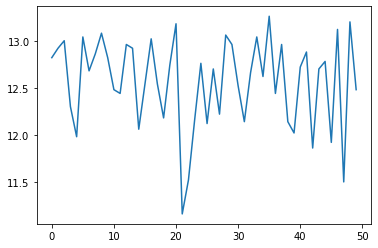

In [31]:
import matplotlib.pyplot as plt

x = range(len(overallscores))
plt.plot(x,overallscores)

NameError: name '__file__' is not defined